# Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.


In [1]:
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, BatchNormalization, Concatenate, MaxPooling2D, Dropout, PReLU
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Lavoriamo da immagini ottenute a partire da MNIST.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

11490434/11490434 [==============================] - 0s 0us/step


Qui viene fornito il generatore che dovete utilizzare per il vostro progetto.
Non modificate in numero di mosse (10), nè il range della traslazione.

Siete liberi di modificare a piacimento la batchsize. Utilizzate x_train per il training e x_valid per la validazione.

In [3]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [4]:
my_gen = generator(x_train,5)

In [5]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Qui potete vedere alcuni esempi restituiti dal generatore
Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


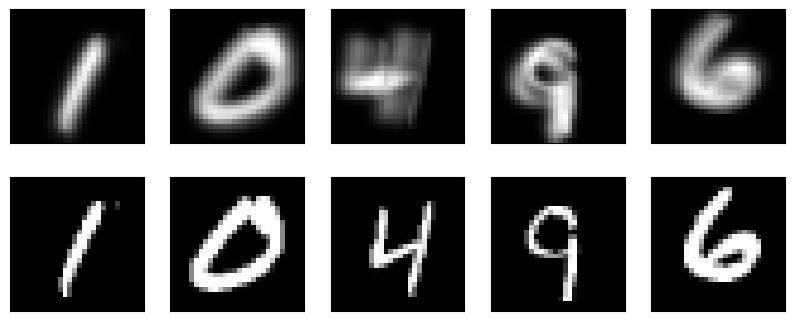

In [6]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set.

Ripetete la computazione precedente per 10 volte, e fornite come risutato la
**media dei 10 round, unitamente alla deviazione standard**.


## Cosa consegnare
Il lavoro deve essere scolto in keras/tensorflow. Consegnate un singolo notebook dove dovete conservare traccia del training.

Discutete e motivate l'architettura finale, cosi come la scelta dei principali iperparametri.

Nome: Jacopo Francesco Cognome: Amoretti 
Matricola: 0001021071

## Creazione del modello

In [7]:
# Funzione di calcolo dell'accuratezza
def pixel_accuracy(y_true, y_pred, threshold=0.1):
    return tf.reduce_mean(tf.cast(tf.less_equal(tf.abs(y_true - y_pred), threshold), tf.float32))

# Definizione del modulo inception
def inception_module(x, filters):
    # Path 1 - Conv 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    # Path 2 - Conv 1x1 seguito da Conv 3x3
    path2 = Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(path2)

    # Path 3 - Conv 1x1 seguito da Conv 5x5
    path3 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(path3)

    # Path 4 - MaxPooling 3x3 seguito da Conv 1x1
    path4 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(path4)

    # Concatenazione finale
    return Concatenate(axis=-1)([path1, path2, path3, path4])

# Definizione del modello 
def deblurring_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    # Blocco convoluzionale 1
    x = Conv2D(32, 3, strides=2, padding='same')(input_img)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)  

    # Blocco convoluzionale 2
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x) 
    conv_block2 = x

    # Blocco convoluzionale 3
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    # Blocco convoluzionale 4
    x = Conv2D(256, 3, strides=1, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    # Primo modulo Inception
    x = inception_module(x, filters=[32, 32, 64, 16, 16, 32])

    # Secondo modulo Inception
    x = inception_module(x, filters=[64, 64, 128, 32, 32, 64])

    # Blocco deconvoluzionale 1
    x = Conv2DTranspose(128, 3, strides=1, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    deconv_block1 = x

    # Concatenazione 
    x = Concatenate()([conv_block2, deconv_block1])

    # Blocco deconvoluzionale 2
    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x) 

    # Terzo modulo Inception
    x = inception_module(x, filters=[32, 32, 64, 16, 16, 32])

    # Quarto modulo Inception
    x = inception_module(x, filters=[64, 64, 128, 32, 32, 64])

    # Blocco deconvoluzionale 3
    x = Conv2DTranspose(32, 3, strides=2 , padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    # Blocco deconvoluzionale 4
    x = Conv2DTranspose(16, 3, strides=1, padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)

    # Output Layer
    decoded = Conv2DTranspose(1, 3, padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='Adam', loss="mean_squared_error", metrics=[pixel_accuracy])
    return autoencoder

# Creazione e sommario del modello
model = deblurring_autoencoder()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 14, 14, 32)           6272      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 32)           128       ['p_re_lu[0][0]']             
 Normalization)                                                                               

## Training

In [8]:
# Preparazione delle immagini generate
x_train_gen,y_train_gen = next(generator(x_train, 100000)) # 100k immagini di training
x_test_gen,y_test_gen = next(generator(x_test, 10000)) # 10k immagini per testare la rete neurale

# Batch e Epoche verificate sperimentalmente
EPOCHS = 25 
BATCH_SIZE = 32

# Funzione per learning dinamico
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

callbacks = [lr_reducer]

# Costruzione del modello
autoencoder = deblurring_autoencoder()

# Training del modello
history = autoencoder.fit(x_train_gen,y_train_gen, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(x_test_gen,y_test_gen),callbacks=callbacks )


Epoch 1/25
3125/3125 [==============================] - 96s 24ms/step - loss: 0.0257 - pixel_accuracy: 0.7964 - val_loss: 0.0162 - val_pixel_accuracy: 0.8452 - lr: 0.0010
Epoch 2/25
3125/3125 [==============================] - 74s 24ms/step - loss: 0.0138 - pixel_accuracy: 0.8599 - val_loss: 0.0111 - val_pixel_accuracy: 0.8757 - lr: 0.0010
Epoch 3/25
3125/3125 [==============================] - 73s 23ms/step - loss: 0.0101 - pixel_accuracy: 0.8842 - val_loss: 0.0070 - val_pixel_accuracy: 0.9065 - lr: 0.0010
Epoch 4/25
3125/3125 [==============================] - 74s 24ms/step - loss: 0.0081 - pixel_accuracy: 0.8994 - val_loss: 0.0052 - val_pixel_accuracy: 0.9229 - lr: 0.0010
Epoch 5/25
3125/3125 [==============================] - 72s 23ms/step - loss: 0.0068 - pixel_accuracy: 0.9094 - val_loss: 0.0044 - val_pixel_accuracy: 0.9320 - lr: 0.0010
Epoch 6/25
3125/3125 [==============================] - 84s 27ms/step - loss: 0.0059 - pixel_accuracy: 0.9173 - val_loss: 0.0038 - val_pixel_accu

## Visualizzazione risultato su 10 immagini di esempio + loss del training

1/1 [==============================] - 1s 1s/step
10


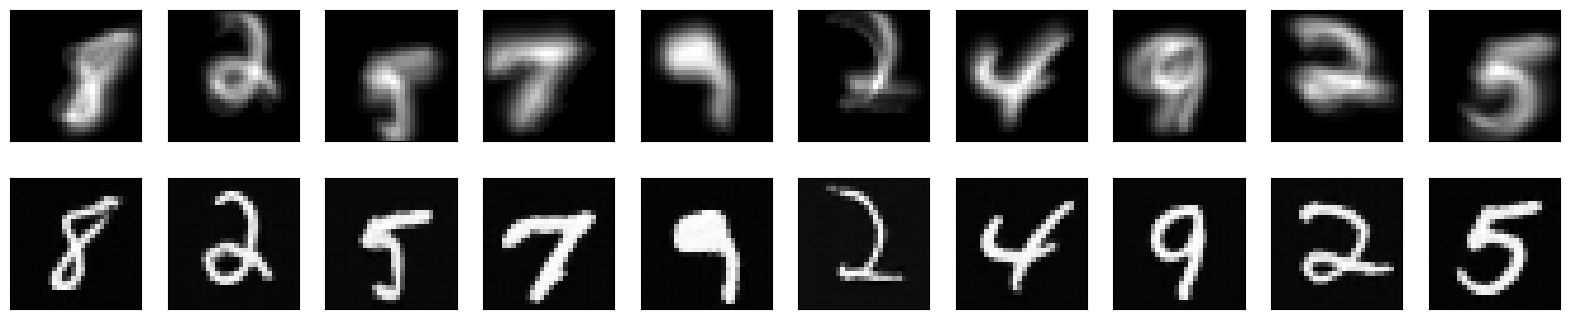

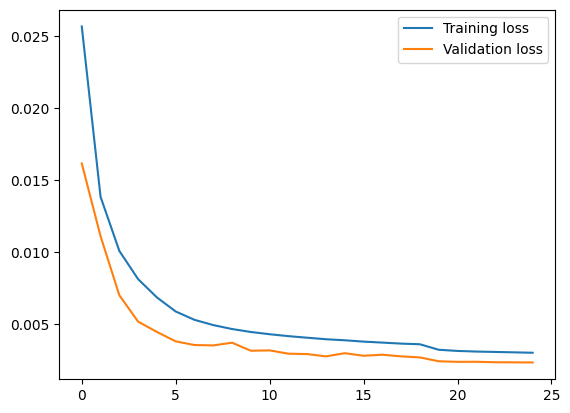

In [9]:
# Genero alcune immagini di test

num_images = 10  # Numero di immagini da visualizzare
test_images, ground_truth = next(generator(x_test, num_images))

# Preprocesso le immagini per il modello
test_images = np.expand_dims(test_images, axis=-1)

# Uso il modello per deblurrare le immagini
deblurred_images = autoencoder.predict(test_images)

# Immagine originale
plot(test_images, deblurred_images)

# Visualiazzione della loss durante il training
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

## Ripetizione per 10 round del mse

313/313 [==============================] - 2s 7ms/step
Media MSE: 0.0023565013
Deviazione standard MSE: 2.37554e-05


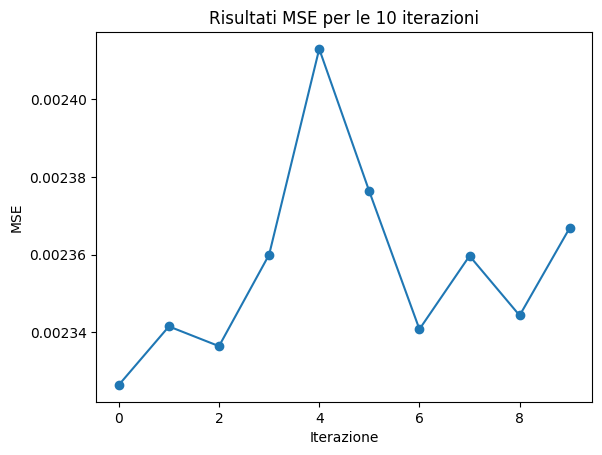

In [10]:
import numpy as np
import matplotlib.pyplot as plt

mse_results = []

for i in range(0, 10):
    test_generator = generator(x_test,10000)
    test_x,test_y = next(test_generator)

    test_x = np.expand_dims(test_x,axis=-1)
    test_y = np.expand_dims(test_y,axis=-1)

    test_y_pred = autoencoder.predict(test_x)
    mse = np.mean(np.square(test_y_pred - test_y))
    mse_results.append(mse)

# Calcolo la media dei risultati
average_mse = np.mean(mse_results)

# Calcolo la deviazione standard dei risultati
std_deviation_mse = np.std(mse_results)

print("Media MSE:", average_mse)
print("Deviazione standard MSE:", std_deviation_mse)

plt.plot(mse_results, marker='o')
plt.xlabel('Iterazione')
plt.ylabel('MSE')
plt.title('Risultati MSE per le 10 iterazioni')
plt.show()

## Motivazione dell'architettura finale e scelta dei principali iperparametri

Per il progetto di deblurring delle immagini MNIST, ho scelto un'architettura di rete neurale convoluzionale (CNN) data la sua efficacia nel riconoscimento di pattern in immagini. In particolare, ho implementato un modello con diversi strati convoluzionali per estrarre le caratteristiche dalle immagini, seguiti da strati deconvolutivi per ricostruire l'immagine senza blur. In particolare il numero di epoche è stato definito in modo sperimentale per assicurare una convergenza adeguata evitando overfitting, mentre il parametro BATCH_SIZE è stato scelto come compromesso per avere una buona capacità di generalizzazione senza rinunciare all'efficienza computazionale.
Per quanto riguarda l'architettura del modello ho scelto un autoencoder poiché l'encoder riduce le dimensioni dell'input, estraendo le caratteristiche essenziali.
I blocchi convolutivi e deconvolutivi sono l'elemento chiave del modello. I primi riducono progressivamente la dimensione spaziale usando dei filtri con differenti profondità (32,64,128) per catturare i vari livelli di astrazione. Mentre i secondi fanno l'opposto ovvero incrementano la dimensione spaziale per ricorstruire l'immagine originale(tramite i Conv2DTranspose i quali sono migliori nel deblurring rispetto agli upsampling perché recuperano dettagli molto piccoli dell'immagine).
Ho usato gli inception module perché consentono al modello di estrarre caratteristiche da diverse scale spaziali simultaneamente, migliorando così la capacità della rete di catturare informazioni dettagliate e di alto livello. Mentre per quanto riguarda le PReLU ho deciso di usarle perché a differenza delle Relu standard si sono rivelate più efficaci così come la scelta dell'ottimizzatore Adam rispetto ad altri ottimizzatori come SGD. 
Al posto di usare un learning rate statico ne ho usato uno dinamico che permette di ridurre il learning rate nel fine-tuning prevenendo l'overfitting, inoltre si sono rivelati molto utili per lo stesso scopo gli strati di dropout che riducendo le dimensioni delle feature map hanno permesso un notevole abbassamento della val_loss.
Ho deciso di usare anche la batch normalization dopo ogni strato convolutivo/deconvolutivo per aiutare a stabilizzare e accelerare l'addestramento e le Skip-Connection per preservare le informazioni spaziali che potrebbero essere perse durante la riduzione delle dimensioni.